# Rewrite Code - Diffusion model
改變：
1. 只有$y_0$從 normal 裡面抽，沒有$x$
2. 'and not DETERMINISTIC' 拿掉
3. 輸出要看到eps

sorce code: Simple file

**目標**
* 利用neural network生成y_hat資料
* 比對y_true : 一堆N(0,1)生成的點(假裝不知道是normal)
* 假設檢定看y_hat跟y_true是否來自相同母群

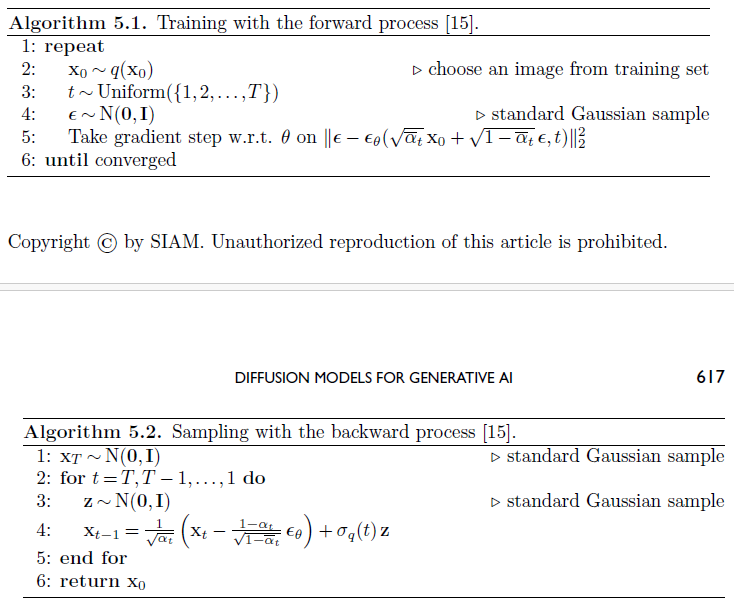


## 10.01 修改部分
1. 將每一步的loss畫出，(理論上要降)：因為感覺code train不太好，或許前100步就已經訓練完了
   * lr=> 5e-4
   * batch size=>512
   * Hidden =>512

In [21]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

### Con fig

In [32]:
DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 512
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 5e-4
HIDDEN        = 512
TIME_DIM      = 64
N_TRAIN_SAMP  = 4096       # 訓練資料量）


In [33]:
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)

In [34]:
### 這塊留給 time embedding
#-------------------------
def sinusoidal_time_emb(t, dim):
    # t: (B,) 的整數 timestep
    device = t.device
    t = t.float().unsqueeze(1)  # (B,1)
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, device=device).float() * (-math.log(10000.0) / max(1, half-1))
    )  # (half,)
    angles = t * freqs  # (B,half)
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B, 2*half)
    if dim % 2 == 1:  # 補一維避免奇數維崩
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb  # (B, dim)

In [43]:
## 建nn
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.time_dim = time_dim
        # 把 time embedding 投影到hidden layer
        self.t_proj = nn.Sequential(
            nn.Linear(time_dim, hidden), 
            nn.SiLU()
            )
        
        # y_t(1維) + time(hidden) → hidden → 1維噪聲預測
        in_dim = hidden + 1 # y+dim=1
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden,1)
        )
    def forward(self, y_t, t):
        t_emb = sinusoidal_time_emb(t, self.time_dim)   # (B, time_dim)
        h_t = self.t_proj(t_emb)                        # (B, hidden)
        h = torch.cat([y_t, h_t], dim=1)                # (B, 1+hidden)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=TRAIN_ITERS, eta_min=1e-5)  ###<---10/1新增

### 10/01 CosineAnnealingLR
新增了這個步驟，意思是lr會隨著訓練step沿著一條餘弦曲線下降。Annealing就是會讓lr逐步減小，讓系統穩定下來。$$\eta_t=\eta_{min}+\frac{1}{2}(\eta_{max}-\eta_{min})(1+\cos(\frac{T_{now}}{T_{max}}\pi))$$

In [44]:
### 計算 y_t= sqrt(abar_t) y0 + sqrt(1-abar_t) * eps
# ---------------------
def q_sample(y0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(y0)   ## 產生跟y0大小一樣的初始normal雜訊
    sa = sqrt_abar[t].view(-1,1)
    som = sqrt_lmabar[t].view(-1,1)
    return sa*y0+som*eps, eps


## Algorithm 1
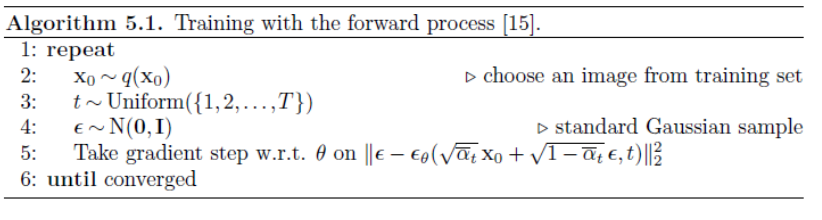

In [45]:
def train_loop(record_step):
    model.train()
    losses =[]
    movavg =[]
    ma=deque(maxlen=50) #長度為50的mov_avg frame

    for step in range(1, TRAIN_ITERS+1):
        # 取 y0~N(0,1)
        y0 = torch.randn(BATCH_SIZE, 1, device=DEVICE)
        # 隨機time step
        t = torch.randint(2,T+1, (BATCH_SIZE,),device=DEVICE).long()
        # 向前加噪
        y_t, eps = q_sample(y0,t)
        # 預測噪音
        eps_hat = model(y_t, t)     
        loss = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none = True) 
        loss.backward()
        #把L2norm限制在1.0以內避免梯度爆炸 ; 但如果loss穩定可以不用
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % record_step ==0: 
            val = loss.detach().item()
            losses.append(val)
            ma.append(val)
            movavg.append(sum(ma)/len(ma))
            print(f"[train] step {step:4d} | loss {loss.item():.6f}")
    
    
    return losses, movavg

## Algorithm 2
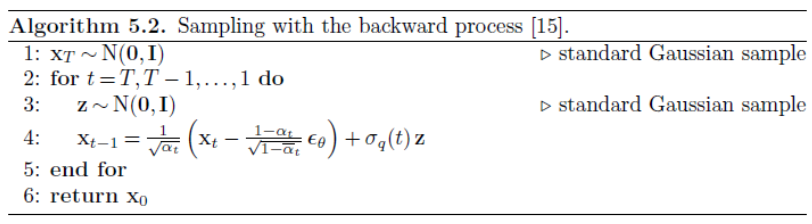

In [46]:
#@torch.no_grad() 是 PyTorch 的一個 decorator（裝飾器），加在函式前面，意思是：
#在這個函式裡面所有的張量運算，都不會被 autograd 記錄梯度。
#這樣可以減少計算消耗

@torch.no_grad()
def sample_on_grid(n_points = 401):
    model.eval()
    # 初始化 y 的 batch，要用 n_points
    y = torch.randn(n_points, 1, device=DEVICE)  ## 直接在N(0,1)裡面抽東西就好
    for t in reversed(range(T+1)):
        tb = torch.full((n_points,), t, device=DEVICE, dtype=torch.long)
        eps_hat = model(y, tb)  ###<<<---已拿掉x
        mean = sqrt_rcp_a[t]*(y - (betas[t]/sqrt_lmabar[t]) * eps_hat) #那行公式
        if t>0:
            y = mean + torch.sqrt(betas[t])*torch.randn_like(y)
        ###<----拿掉else
    
    return y.squeeze(1).cpu() 

---

## TEST

[train] step    1 | loss 0.862262
[train] step    2 | loss 0.974801
[train] step    3 | loss 0.857090
[train] step    4 | loss 0.742843
[train] step    5 | loss 0.915859
[train] step    6 | loss 0.922630
[train] step    7 | loss 0.823577
[train] step    8 | loss 0.755611
[train] step    9 | loss 0.828918
[train] step   10 | loss 0.903232
[train] step   11 | loss 0.772740
[train] step   12 | loss 0.759206
[train] step   13 | loss 0.737603
[train] step   14 | loss 0.620996
[train] step   15 | loss 0.695850
[train] step   16 | loss 0.659554
[train] step   17 | loss 0.604037
[train] step   18 | loss 0.545798
[train] step   19 | loss 0.555387
[train] step   20 | loss 0.608558
[train] step   21 | loss 0.481822
[train] step   22 | loss 0.439848
[train] step   23 | loss 0.531378
[train] step   24 | loss 0.549862
[train] step   25 | loss 0.419366
[train] step   26 | loss 0.502678
[train] step   27 | loss 0.488319
[train] step   28 | loss 0.466911
[train] step   29 | loss 0.381097
[train] step  

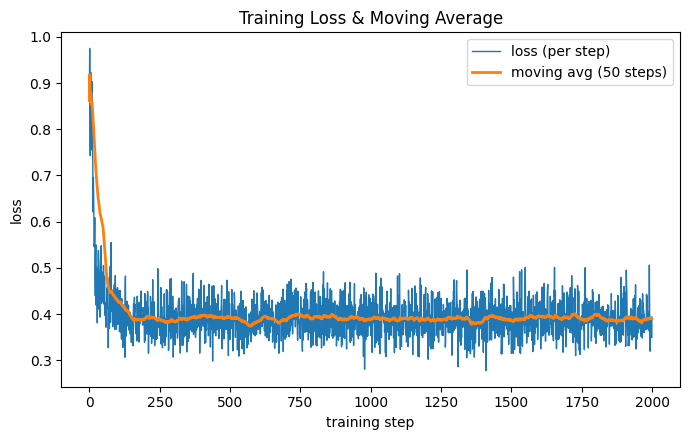

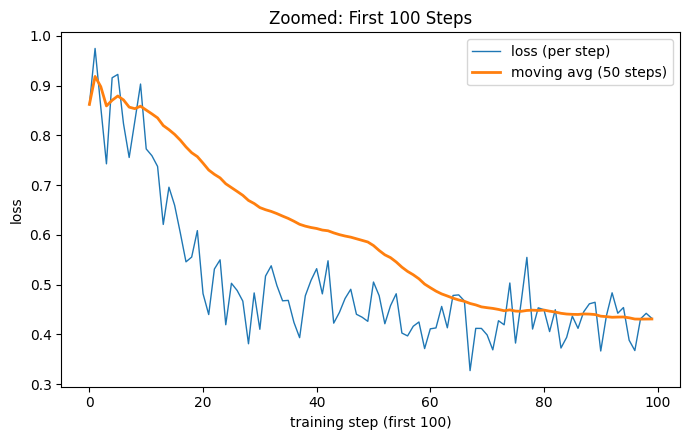

In [47]:
losses, movavg=train_loop(record_step=1)
steps = np.arange(len(losses))
y_hat = sample_on_grid(n_points = 401)

# 全部步數
plt.figure(figsize=(7,4.5))
plt.plot(steps, losses, label="loss (per step)", linewidth=1)
plt.plot(steps, movavg, label="moving avg (50 steps)", linewidth=2)
plt.xlabel("training step")
plt.ylabel("loss")
plt.title("Training Loss & Moving Average")
plt.legend()
plt.tight_layout()
plt.show()

# 前 100 步局部放大（線性 y 軸）
k = min(100, len(losses))
plt.figure(figsize=(7,4.5))
plt.plot(steps[:k], losses[:k], label="loss (per step)", linewidth=1)
plt.plot(steps[:k], movavg[:k], label="moving avg (50 steps)", linewidth=2)
plt.xlabel("training step (first 100)")
plt.ylabel("loss")
plt.title("Zoomed: First 100 Steps")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
print(type(opt))
for i, g in enumerate(opt.param_groups):
    print(f"group {i} lr={g['lr']}")

<class 'torch.optim.adamw.AdamW'>
group 0 lr=0.0005


### 10/01小結:
對於訓練模型有好結果，從毫無下降到明顯下降。

In [48]:
y_true = torch.randn(BATCH_SIZE, 1, device=DEVICE)

print("y_hat: ", y_hat)
print("y_true: ", y_true)   

y_hat:  tensor([-0.6245,  0.7217, -0.3545,  1.3667,  2.0543, -0.7065,  1.3537,  0.9536,
        -0.9562,  0.8872, -1.7144,  1.5286,  0.0553,  1.8962, -0.9170, -0.7630,
        -0.4970,  1.3355,  0.9731, -0.6482,  0.0133, -0.7616,  0.2269, -0.0384,
         0.5917, -0.5371,  0.3759, -0.3211,  0.9404,  0.2974, -1.1921, -0.0554,
        -0.4157,  1.5332,  2.1112,  0.3991, -1.2113, -0.3815,  0.5002,  1.0616,
        -0.0734,  0.1350,  0.5070,  0.3551,  0.3903, -0.4841, -1.2459,  1.4384,
        -0.5900, -0.4040,  1.1718,  1.5810, -0.3776, -2.1635,  1.5551,  0.9127,
         0.4951, -1.1734,  0.3987, -0.1561, -1.1953,  0.9611,  0.5672, -0.9048,
         1.5931, -1.0758, -0.3235, -0.7167,  0.4488,  0.2464, -0.2993,  0.9144,
         0.6689, -0.1771,  0.0256,  1.5762,  1.0191,  1.2517, -0.0333,  1.2170,
         1.3491, -0.4291, -0.9096,  0.2117,  0.2386, -0.1671,  1.0265, -0.8591,
        -1.3071, -0.8271,  0.1267, -2.5228,  0.3680,  1.8823,  1.1367, -0.7598,
         0.3719, -1.9241, -0.856

## Plot

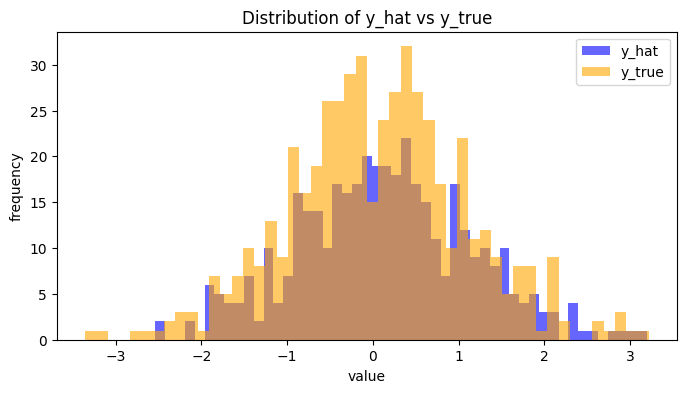

In [49]:
import matplotlib.pyplot as plt

# 如果在 GPU，要先搬回 CPU
y_hat_np = y_hat.detach().cpu().numpy().flatten()
y_true_np = y_true.detach().cpu().numpy().flatten()

plt.figure(figsize=(8,4))

# 畫 y_hat 的直方圖
plt.hist(y_hat_np, bins=50, alpha=0.6, color='blue', label='y_hat')

# 畫 y_true 的直方圖
plt.hist(y_true_np, bins=50, alpha=0.6, color='orange', label='y_true')

plt.legend()
plt.xlabel("value")
plt.ylabel("frequency")
plt.title("Distribution of y_hat vs y_true")
plt.show()


---

# NEW AREA -> Statistic Analysis
目標: 看y_hat跟y_true的母群是否相似 (POV:假裝不知道y_true是normal來的)


In [50]:
import numpy as np
from scipy.stats import ks_2samp, epps_singleton_2samp, levene, ttest_ind

In [51]:
# 1) 取資料（確保 shape 與裝置一致）
y_hat_np  = y_hat.detach().cpu().numpy().ravel()
y_true_np = y_true.detach().cpu().numpy().ravel()

# 2) 可選：讓樣本數一致（避免樣本量差異影響）
n = min(len(y_hat_np), len(y_true_np))
rng = np.random.default_rng(0)
y_hat_s  = rng.choice(y_hat_np,  n, replace=False)
y_true_s = rng.choice(y_true_np, n, replace=False)

# 3) 兩樣本分布檢定
ks_stat, ks_p = ks_2samp(y_hat_s, y_true_s)                 # KS 檢定（對整體CDF差異敏感）
es_stat, es_p = epps_singleton_2samp(y_hat_s, y_true_s)     # Epps–Singleton（對形狀差更敏感）

# 4) 均值、變異的簡單比較（非必要，但有助判讀差異來源）
t_stat, t_p   = ttest_ind(y_hat_s, y_true_s, equal_var=False)
lev_stat, lev_p = levene(y_hat_s, y_true_s)                 # 變異是否相等

print(f"KS: stat={ks_stat:.3f}, p={ks_p:.3g}")
print(f"Epps–Singleton: stat={es_stat:.3f}, p={es_p:.3g}")
print(f"t-test (means): stat={t_stat:.3f}, p={t_p:.3g}")
print(f"Levene (variances): stat={lev_stat:.3f}, p={lev_p:.3g}")

# 5) 幾個摘要統計（幫助你直覺比較）
def summary(a, name):
    print(name, "mean=", np.mean(a), "std=", np.std(a), "kurtosis≈", (np.mean(((a-np.mean(a))/np.std(a))**4)-3))
summary(y_hat_s,  "y_hat")
summary(y_true_s, "y_true")


KS: stat=0.050, p=0.702
Epps–Singleton: stat=2.559, p=0.634
t-test (means): stat=1.082, p=0.28
Levene (variances): stat=0.125, p=0.724
y_hat mean= 0.1459736 std= 1.0172428 kurtosis≈ -0.066114664
y_true mean= 0.06721735 std= 1.041299 kurtosis≈ 0.24854875


## 10/01統計檢驗結果

- **Kolmogorov–Smirnov (KS)**: stat = 0.050, p = 0.702  
  → 無法拒絕同分佈假設。

- **Epps–Singleton test**: stat = 2.559, p = 0.634  
  → 無顯著差異。

- **t-test (均值比較)**: stat = 1.082, p = 0.280  
  → 均值無顯著差異。

- **Levene test (變異數比較)**: stat = 0.125, p = 0.724  
  → 變異數無顯著差異。

---

### 數據摘要

|            | Mean    | Std      | Kurtosis  |
|------------|---------|----------|-----------|
| **y_hat**  | 0.146   | 1.017    | -0.066    |
| **y_true** | 0.067   | 1.041    | 0.249     |

- 均值差距約 **0.08**，相對於 \(\sigma \approx 1\) 屬於**很小**。  
- 標準差幾乎一致。  
- 峰態：\(y_{\hat{}}\) 略偏平頂（尾部略薄），但幅度很小。

---

### 結論

- CDF 圖顯示 \(y_{\hat{}}\) 與 \(y_{\text{true}}\) 幾乎重合。  
- 各項檢驗 p 值皆遠大於 0.05，無顯著差異。  
- 整體而言，模型生成分佈與真實分佈高度一致。

---


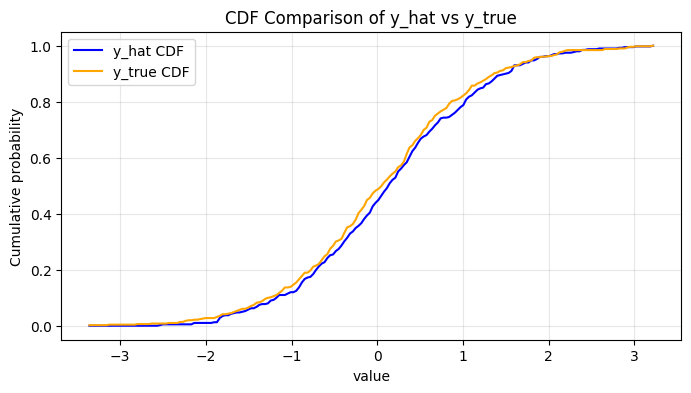

In [52]:
def plot_cdf_comparison(y_hat, y_true, bins=200):
    # 轉 numpy
    y_hat_np  = y_hat.detach().cpu().numpy().ravel()
    y_true_np = y_true.detach().cpu().numpy().ravel()

    # 共同範圍
    lo = min(y_hat_np.min(), y_true_np.min())
    hi = max(y_hat_np.max(), y_true_np.max())
    grid = np.linspace(lo, hi, bins)

    # 計算 CDF
    y_hat_cdf  = np.searchsorted(np.sort(y_hat_np), grid, side="right") / len(y_hat_np)
    y_true_cdf = np.searchsorted(np.sort(y_true_np), grid, side="right") / len(y_true_np)

    
    plt.figure(figsize=(8,4))
    plt.plot(grid, y_hat_cdf, label="y_hat CDF", color="blue")
    plt.plot(grid, y_true_cdf, label="y_true CDF", color="orange")
    plt.xlabel("value")
    plt.ylabel("Cumulative probability")
    plt.title("CDF Comparison of y_hat vs y_true")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


plot_cdf_comparison(y_hat, y_true)



#### 建議（進一步分析）

- 可加報 **Wasserstein-1 距離 (EMD)** 或 **Cramér–von Mises 檢驗**，作為分佈差異的效應量。  
- 加繪 **QQ-plot** 以檢查尾部對齊情況。  
- 若要降低尾部差距，可嘗試 **Huber loss** 或 **Min-SNR reweighting**，或以 **v-prediction** 做對照。  
- 在取樣階段，可測試 **DDIM (η=0)** 以獲得更平滑、低噪聲的分佈。